# Credit Card Fraud Detection
This is a project that utilize Kaggle dataset: Credit Card Transactions to construct a machine learning model for fraudulent transaction detection.

## Project overview
In this project, I will construct fraud detection models base on the following steps:
1. Data cleaning: remove records with transaction amount < 0 
2. Data combination: combine files with user and credit card information with the transaction record data
3. Feature engineering: create feautures that might be useful for model classification
4. Downsampling: since the data is extremely imbalanced (≈0.1% of fraudulent transaction) and the transaction data is large, downsampling can be useful to create model with better performance and obtaining important features
5. Model construction: considering model efficiency and accuracy, I construct Logistic Regression, XGBoost, and Gradient Boosting Classifier.
6. Visualizing the results

## Data Introduction
The datasets consists of three .csv files
* Credit Card Transaction: >20 million record of credit card transaction records
* Users: Some information about the simulated people, including gender, age, income, etc.
* Card: Some information about the simlated credit cards

For more about the dataset, please check: https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions

## Environment Setup

In [1]:
## Import packages
import gc
import warnings
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import multiprocessing as mp 
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from category_encoders.binary import BinaryEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline 
import matplotlib.pyplot as plt

In [2]:
## Import datasets from Kaggle
df = pd.read_csv('/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv')
user = pd.read_csv('/kaggle/input/credit-card-transactions/sd254_users.csv')
card = pd.read_csv('/kaggle/input/credit-card-transactions/sd254_cards.csv')

## Data Processing
In this section, I will clean and create features within the three different files

### User Information
* Create user id "User"
* Remove the dollar sign before "Yearly Income - Person", "Total Debt", "Per Capita Income - Zipcode"
* Create the following features:
    1. Retired: Yes if current age > retirement age
    2. $Person\ Location\ Income\ ratio = \frac{(Yearly\ Income\ -\ Person)}{(User\ Location\ Income + 0.01)}$
    3. $Person\ Income\ toDebt = \frac{(Yearly\ Income\ -\ Person)}{(Total\ Debt + 0.01)}$
    4. $Location\ Income\ toDebt = \frac{(User\ Location\ Income)}{(Total\ Debt + 0.01)}$  
* These variables are created because they can possibly representing the income level and financial pressure of users, which can be associated with fraudulent transaction

In [3]:
## Data preprocessing for user
user["User"] = range(2000) # create User ID to join with 'card'

## Remove the dollar signs
user["Yearly Income - Person"] = user["Yearly Income - Person"].str.replace("$", "").astype(float)
user["Total Debt"] = user["Total Debt"].str.replace("$", "").astype(float)
user["User_Location_Income"] = user["Per Capita Income - Zipcode"].str.replace("$", "").astype(float)

## Define new variable indicating users retirement status
user['Retired'] = 'No'
user.loc[user['Current Age'] > user['Retirement Age'], 'Retired'] = 'Yes'

## Define variables that are the ratio of their income, debt, and the income level at their location
user['Person_Location_Income_ratio'] = user["Yearly Income - Person"]/(user["User_Location_Income"] + 0.01)
user['Person_Income_toDebt'] = user["Yearly Income - Person"]/(user["Total Debt"] + 0.01)
user['Location_Income_toDebt'] = user["User_Location_Income"]/(user["Total Debt"] + 0.01)

## Select variables use for further analysis
user = user[['User', 'Gender', "Current Age", "Retired", "User_Location_Income", 'Yearly Income - Person', "Total Debt", "Num Credit Cards", 'Person_Location_Income_ratio','Person_Income_toDebt','Location_Income_toDebt']]

## Take a look at the data
user.head()

,User,Gender,Current Age,Retired,User_Location_Income,Yearly Income - Person,Total Debt,Num Credit Cards,Person_Location_Income_ratio,Person_Income_toDebt,Location_Income_toDebt
0,0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
1,1,Female,53,No,37891.0,77254.0,191349.0,5,2.038848,0.403733,0.198020
2,2,Female,81,Yes,22681.0,33483.0,196.0,5,1.476257,170.822917,115.713484
3,3,Female,63,No,163145.0,249925.0,202328.0,4,1.531919,1.235247,0.806339
4,4,Male,43,No,53797.0,109687.0,183855.0,1,2.038905,0.596595,0.292606


### Card Information
* Create index "User_Card" 
* Join with user information

In [4]:
## Data preprocessing for cards
card["User_Card"] = card['User'].astype(str) + '_' + card['CARD INDEX'].astype(str) ## Create card id to join with transaction data

## Remove the dollor sign
card["Credit Limit"] = card["Credit Limit"].str.replace("$", "").astype(float)

## Select variables of interest
card = card[["User_Card", "User", 'Card Brand', "Card Type", "Credit Limit"]]

## Left join with 'user'
card = card.merge(user, on='User', how='left')
card = card.drop(columns=['User'])

## Take a look
card.head()

,User_Card,Card Brand,Card Type,Credit Limit,Gender,Current Age,Retired,User_Location_Income,Yearly Income - Person,Total Debt,Num Credit Cards,Person_Location_Income_ratio,Person_Income_toDebt,Location_Income_toDebt
0,0_0,Visa,Debit,24295.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
1,0_1,Visa,Debit,21968.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
2,0_2,Visa,Debit,46414.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
3,0_3,Visa,Credit,12400.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
4,0_4,Mastercard,Debit (Prepaid),28.0,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428


### Transaction Data
* Join with card and user information
* Remove the dollar sign before "Amount" and remove data with negative transaction amount
* Remove columns such as errors, merchant name, these columns are either too many missing values or hard to interpret
* Create Day of the week
* Create Time of the day (when the transaction occur, separating a day into 8 periods)
    * Midnight (23-2), Early Morning (2-5), Morning (5-8), Late Morning (8-11), Noon (11-14), Afternoon (14-17), Evening (17-20), Late Night (20-23)
* Create The last digit of tranaction amount

In [5]:
## Create the 'User_Card' index to join with credit card information
df["User_Card"] = df['User'].astype(str) + '_' + df['Card'].astype(str)

# Remove the dollar sign
df["Amount"] = df["Amount"].str.replace("$", "").astype(float)

## Keep data with positive amount
df = df[df['Amount'] > 0]
df = df.merge(card, on='User_Card', how='left')

## Remove columns that will not be used
df = df.drop(columns=['User', 'Card', 'User_Card', "Errors?", "Merchant Name", "Merchant State", "Zip", 'MCC'])
df.head()

,Year,Month,Day,Time,Amount,Use Chip,Merchant City,Is Fraud?,Card Brand,Card Type,...,Gender,Current Age,Retired,User_Location_Income,Yearly Income - Person,Total Debt,Num Credit Cards,Person_Location_Income_ratio,Person_Income_toDebt,Location_Income_toDebt
0,2002,9,1,06:21,134.09,Swipe Transaction,La Verne,No,Visa,Debit,...,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
1,2002,9,1,06:42,38.48,Swipe Transaction,Monterey Park,No,Visa,Debit,...,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
2,2002,9,2,06:22,120.34,Swipe Transaction,Monterey Park,No,Visa,Debit,...,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
3,2002,9,2,17:45,128.95,Swipe Transaction,Monterey Park,No,Visa,Debit,...,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428
4,2002,9,3,06:23,104.71,Swipe Transaction,La Verne,No,Visa,Debit,...,Female,53,No,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428


In [6]:
## Create a column with combined transcation time
df["Transcation_Time"] = df["Year"].astype(str) + '-' + df["Month"].astype(str) + '-' + df["Day"].astype(str) + ' ' + df["Time"]
df["Transcation_Time"] = pd.to_datetime(df["Transcation_Time"])

## Day of the weel
df["Weekday"] = df["Transcation_Time"].dt.day_name()

## Split the time of day into 8 different periods based on hour
df['Time_of_Day'] = ''
df.loc[(df['Transcation_Time'].dt.hour >= 23) | (df['Transcation_Time'].dt.hour < 2), 'Time_of_Day'] = 'Midnight'
df.loc[(df['Transcation_Time'].dt.hour >= 2) & (df['Transcation_Time'].dt.hour < 5), 'Time_of_Day'] = 'Early Morning'
df.loc[(df['Transcation_Time'].dt.hour >= 5) & (df['Transcation_Time'].dt.hour < 8), 'Time_of_Day'] = 'Morning'
df.loc[(df['Transcation_Time'].dt.hour >= 8) & (df['Transcation_Time'].dt.hour < 11), 'Time_of_Day'] = 'Late Morning'
df.loc[(df['Transcation_Time'].dt.hour >= 11) & (df['Transcation_Time'].dt.hour < 14), 'Time_of_Day'] = 'Noon'
df.loc[(df['Transcation_Time'].dt.hour >= 14) & (df['Transcation_Time'].dt.hour < 17), 'Time_of_Day'] = 'Afternoon'
df.loc[(df['Transcation_Time'].dt.hour >= 17) & (df['Transcation_Time'].dt.hour < 20), 'Time_of_Day'] = 'Evening'
df.loc[(df['Transcation_Time'].dt.hour >= 20) & (df['Transcation_Time'].dt.hour < 23), 'Time_of_Day'] = 'Late Night'

## The last digit of the transaction amount can be a trait of fraud
df['last_digit'] = df['Amount'].astype(str).str[-1]

## Remove columns that will not be used
df = df.drop(columns=["Time", "Transcation_Time"])

## Show what the dataframe looks like after all the steps
df.head(10)

,Year,Month,Day,Amount,Use Chip,Merchant City,Is Fraud?,Card Brand,Card Type,Credit Limit,...,User_Location_Income,Yearly Income - Person,Total Debt,Num Credit Cards,Person_Location_Income_ratio,Person_Income_toDebt,Location_Income_toDebt,Weekday,Time_of_Day,last_digit
0,2002,9,1,134.09,Swipe Transaction,La Verne,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Sunday,Morning,9
1,2002,9,1,38.48,Swipe Transaction,Monterey Park,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Sunday,Morning,8
2,2002,9,2,120.34,Swipe Transaction,Monterey Park,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Monday,Morning,4
3,2002,9,2,128.95,Swipe Transaction,Monterey Park,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Monday,Evening,5
4,2002,9,3,104.71,Swipe Transaction,La Verne,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Tuesday,Morning,1
5,2002,9,3,86.19,Swipe Transaction,Monterey Park,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Tuesday,Noon,9
6,2002,9,4,93.84,Swipe Transaction,Monterey Park,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Wednesday,Morning,4
7,2002,9,4,123.50,Swipe Transaction,Monterey Park,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Wednesday,Morning,5
8,2002,9,5,61.72,Swipe Transaction,Monterey Park,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Thursday,Morning,2
9,2002,9,5,57.10,Swipe Transaction,La Verne,No,Visa,Debit,24295.0,...,29278.0,59696.0,127613.0,5,2.038936,0.467789,0.229428,Thursday,Late Morning,1


## Downsampling and Data Preprocessing
In this section, the cleaned data will be processed by:
1. Downsampling to 500,000 records with 5% of fraudulent transaction
2. Transforming through one-hot encoder (for categorical variables) and scaling (for numerical variables)
3. Spliting into training (80%) and testing (20%) sets with similar proportion of fraudulent transaction

In [7]:
from sklearn.compose import make_column_selector as selector

## Define a function for data preprocessing
def data_preprocessing(X):
    ## Separate the column by numerical or categorical
    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)
    numerical_columns = numerical_columns_selector(X)
    categorical_columns = categorical_columns_selector(X)
    
    ## One Hot encoding the categorical varaibles and scale the numerical ones
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("one-hot-encoder", categorical_preprocessor, categorical_columns),
            ("standard_scaler", numerical_preprocessor, numerical_columns)
        ]
    )
    ## Transform the variable
    X_preprocessed = preprocessor.fit_transform(X)
    ## Save the feture names for variable importance
    feature_names = preprocessor.get_feature_names_out()
    
    return X_preprocessed, feature_names

In [8]:
def resample_split(rsd):
    # Calculate the desired number of fraud cases based on the desired proportion
    desired_proportion = 0.05
    total_samples = 500000
    fraud_samples = int(total_samples * desired_proportion)
    
    # Create RandomUnderSampler with the desired sampling strategy
    rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state = rsd)
    
    # Apply random undersampling to the original dataset
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    ## Perform data preprocessing on the reampled data, and keep the feature names
    X_preprocessed, feature_names = data_preprocessing(X_resampled)
    
    # Split the resampled data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_resampled, test_size=0.2, stratify=y_resampled, random_state = rsd)
    
    return X_train, X_test, y_train, y_test

In [9]:
## Select columns that will be used for model construction
col_formd = ["Merchant City", "Gender", "Current Age", 'Card Brand', "Card Type", "Credit Limit", "Amount", "Use Chip", "Year", "Month", "Retired", "Person_Location_Income_ratio", "Person_Income_toDebt", "Location_Income_toDebt", "Weekday", "Time_of_Day", "last_digit"]

In [10]:
# Split the dataset into features (X) and target variable (y)
X = df[col_formd]
y = df['Is Fraud?'].apply(lambda x: 1 if x == 'Yes' else 0)
y.sum()

28619

In [11]:
X.head()

,Merchant City,Gender,Current Age,Card Brand,Card Type,Credit Limit,Amount,Use Chip,Year,Month,Retired,Person_Location_Income_ratio,Person_Income_toDebt,Location_Income_toDebt,Weekday,Time_of_Day,last_digit
0,La Verne,Female,53,Visa,Debit,24295.0,134.09,Swipe Transaction,2002,9,No,2.038936,0.467789,0.229428,Sunday,Morning,9
1,Monterey Park,Female,53,Visa,Debit,24295.0,38.48,Swipe Transaction,2002,9,No,2.038936,0.467789,0.229428,Sunday,Morning,8
2,Monterey Park,Female,53,Visa,Debit,24295.0,120.34,Swipe Transaction,2002,9,No,2.038936,0.467789,0.229428,Monday,Morning,4
3,Monterey Park,Female,53,Visa,Debit,24295.0,128.95,Swipe Transaction,2002,9,No,2.038936,0.467789,0.229428,Monday,Evening,5
4,La Verne,Female,53,Visa,Debit,24295.0,104.71,Swipe Transaction,2002,9,No,2.038936,0.467789,0.229428,Tuesday,Morning,1


In [12]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Is Fraud?, dtype: int64

In [13]:
## Assign seed for each repetitions
sd_list = [1234, 3456, 4567, 6789, 7890, 1111, 2222, 3333, 4444, 5555, 6666, 7777, 8888, 9999, 1010, 2020, 3030, 4040, 5050, 6060, 7070, 8080, 9090, 8765, 4321, 9054, 3388, 3360, 3596, 1998]

for rsd in sd_list:
    X_train, X_test, y_train, y_test = resample_split(rsd)
    

# Logistic Regression

In [14]:
results=dict()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Mendefinisikan model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Membuat prediksi
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Menyimpan hasil ke dalam dictionary
results["LogisticRegression"] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC': mcc,
    'AUC': auc
}

# Menampilkan hasil
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"MCC: {mcc}")
print(f"AUC: {auc}")


# Menampilkan dictionary hasil
print(results)

Logistic Regression Results:
Accuracy: 0.96281
Precision: 0.8184982595723521
Recall: 0.3292
F1 Score: 0.4695478533732706
MCC: 0.5051419727375662
AUC: 0.9420566484210526
{'LogisticRegression': {'Accuracy': 0.96281, 'Precision': 0.8184982595723521, 'Recall': 0.3292, 'F1 Score': 0.4695478533732706, 'MCC': 0.5051419727375662, 'AUC': 0.9420566484210526}}


<Axes: >

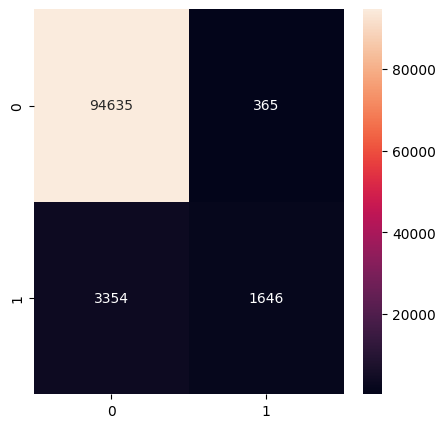

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix,annot=True,fmt='d')

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Mendefinisikan model
logreg = LogisticRegression()

# Mendefinisikan metrik evaluasi
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc'
}

# Melakukan cross-validation dan menyimpan hasilnya
scores = cross_validate(logreg, X_train, y_train, cv=5, scoring=scoring)

# Menampilkan hasil cross-validation
print("Cross Validation Results:")
print(f"Accuracy: {scores['test_accuracy']}")
print(f"Precision: {scores['test_precision']}")
print(f"Recall: {scores['test_recall']}")
print(f"F1 Score: {scores['test_f1']}")
print(f"MCC: {scores['test_mcc']}")
print(f"AUC: {scores['test_roc_auc']}")
print("")
print("Average Accuracy:", scores['test_accuracy'].mean())
print("Average Precision:", scores['test_precision'].mean())
print("Average Recall:", scores['test_recall'].mean())
print("Average F1 Score:", scores['test_f1'].mean())
print("Average MCC:", scores['test_mcc'].mean())
print("Average AUC:", scores['test_roc_auc'].mean())

Cross Validation Results:
Accuracy: [0.96235  0.963125 0.962625 0.96345  0.9637  ]
Precision: [0.81505102 0.8458498  0.83443709 0.85348226 0.84639697]
Recall: [0.3195  0.321   0.315   0.32475 0.33475]
F1 Score: [0.45905172 0.46538601 0.45735027 0.47048171 0.47975636]
MCC: [0.49632937 0.50784966 0.49922074 0.51340826 0.5190129 ]
AUC: [0.93772797 0.94129073 0.93976117 0.94283921 0.94179049]

Average Accuracy: 0.96305
Average Precision: 0.8390434269844761
Average Recall: 0.32300000000000006
Average F1 Score: 0.4664052150094341
Average MCC: 0.5071641859237979
Average AUC: 0.9406819138157895


# XGBoost

In [18]:
import xgboost as xgb

# Mendefinisikan model XGBClassifier (XGBoost)
xgb_model = xgb.XGBClassifier()

# Melatih model
xgb_model.fit(X_train, y_train)

# Membuat prediksi
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Menyimpan hasil ke dalam dictionary
results["XGBClassifier"] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC': mcc,
    'AUC': auc
}

# Menampilkan hasil evaluasi
print("XGBClassifier Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"MCC: {mcc}")
print(f"AUC: {auc}")

# Menampilkan dictionary hasil
print(results)

XGBClassifier Results:
Accuracy: 0.97837
Precision: 0.8658756770698994
Recall: 0.6714
F1 Score: 0.7563366002027713
MCC: 0.7518157566346277
AUC: 0.9843133168421052
{'LogisticRegression': {'Accuracy': 0.96281, 'Precision': 0.8184982595723521, 'Recall': 0.3292, 'F1 Score': 0.4695478533732706, 'MCC': 0.5051419727375662, 'AUC': 0.9420566484210526}, 'XGBClassifier': {'Accuracy': 0.97837, 'Precision': 0.8658756770698994, 'Recall': 0.6714, 'F1 Score': 0.7563366002027713, 'MCC': 0.7518157566346277, 'AUC': 0.9843133168421052}}


<Axes: >

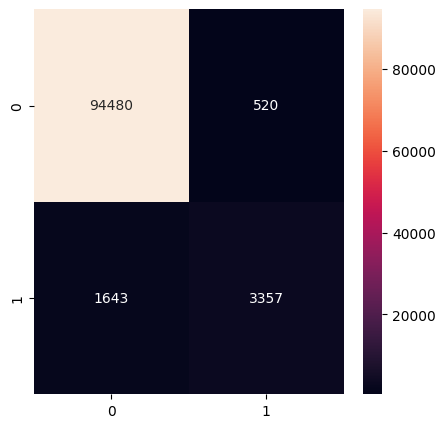

In [19]:
cf_matrix=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix,annot=True,fmt='d')

In [20]:
# Mendefinisikan model XGBClassifier (XGBoost)
xgb_model = xgb.XGBClassifier()

# Mendefinisikan metrik evaluasi
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc'
}

# Melakukan cross-validation dan menyimpan hasilnya
scores = cross_validate(xgb_model, X_train, y_train, cv=5, scoring=scoring)

# Menampilkan hasil cross-validation
print("Cross Validation Results:")
print(f"Accuracy: {scores['test_accuracy']}")
print(f"Precision: {scores['test_precision']}")
print(f"Recall: {scores['test_recall']}")
print(f"F1 Score: {scores['test_f1']}")
print(f"MCC: {scores['test_mcc']}")
print(f"AUC: {scores['test_roc_auc']}")
print("")
print("Average Accuracy:", scores['test_accuracy'].mean())
print("Average Precision:", scores['test_precision'].mean())
print("Average Recall:", scores['test_recall'].mean())
print("Average F1 Score:", scores['test_f1'].mean())
print("Average MCC:", scores['test_mcc'].mean())
print("Average AUC:", scores['test_roc_auc'].mean())

Cross Validation Results:
Accuracy: [0.97755   0.9783625 0.97715   0.97865   0.9778375]
Precision: [0.85297886 0.87014682 0.85191186 0.87183647 0.85838429]
Recall: [0.66575 0.66675 0.65725 0.67175 0.66675]
F1 Score: [0.74782365 0.75498938 0.74202653 0.75882519 0.75052765]
MCC: [0.74245941 0.75110052 0.73701291 0.75481571 0.74558693]
AUC: [0.98125739 0.98182212 0.98258648 0.98173535 0.98122067]

Average Accuracy: 0.97791
Average Precision: 0.8610516603994267
Average Recall: 0.66565
Average F1 Score: 0.7508384799883221
Average MCC: 0.7461950951152072
Average AUC: 0.9817244009868421


# Gradient Boosting Classifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

# Inisialisasi model Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

# Melatih model menggunakan data training (x_train dan y_train)
gbc.fit(X_train, y_train)

# Melakukan prediksi menggunakan data testing (x_test)
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)[:, 1]  # Untuk ROC AUC

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Menyimpan hasil evaluasi ke dalam dictionary model_result
results["GradientBoostingClassifier"] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC': mcc,
    'AUC': auc
}

# Menampilkan hasil evaluasi
print("Gradient Boosting Classifier Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"MCC: {mcc}")
print(f"ROC AUC: {auc}")

# Menampilkan dictionary hasil
print(results)

Gradient Boosting Classifier Results:
Accuracy: 0.96991
Precision: 0.8265004919645785
Recall: 0.504
F1 Score: 0.62616474096161
MCC: 0.6318260039357578
ROC AUC: 0.9570558705263159
{'LogisticRegression': {'Accuracy': 0.96281, 'Precision': 0.8184982595723521, 'Recall': 0.3292, 'F1 Score': 0.4695478533732706, 'MCC': 0.5051419727375662, 'AUC': 0.9420566484210526}, 'XGBClassifier': {'Accuracy': 0.97837, 'Precision': 0.8658756770698994, 'Recall': 0.6714, 'F1 Score': 0.7563366002027713, 'MCC': 0.7518157566346277, 'AUC': 0.9843133168421052}, 'GradientBoostingClassifier': {'Accuracy': 0.96991, 'Precision': 0.8265004919645785, 'Recall': 0.504, 'F1 Score': 0.62616474096161, 'MCC': 0.6318260039357578, 'AUC': 0.9570558705263159}}


<Axes: >

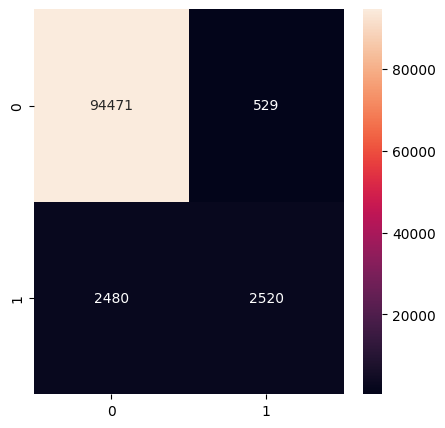

In [22]:
cf_matrix=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix,annot=True,fmt='d')

In [23]:
# Mendefinisikan model Gradient Boosting Classifier (GBC)
gbc_model = GradientBoostingClassifier()

# Mendefinisikan metrik evaluasi
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': 'roc_auc'
}

# Melakukan cross-validation dan menyimpan hasilnya
scores = cross_validate(gbc_model, X_train, y_train, cv=5, scoring=scoring)

# Menampilkan hasil cross-validation
print("Cross Validation Results:")
print(f"Accuracy: {scores['test_accuracy']}")
print(f"Precision: {scores['test_precision']}")
print(f"Recall: {scores['test_recall']}")
print(f"F1 Score: {scores['test_f1']}")
print(f"MCC: {scores['test_mcc']}")
print(f"AUC: {scores['test_roc_auc']}")
print("")
print("Average Accuracy:", scores['test_accuracy'].mean())
print("Average Precision:", scores['test_precision'].mean())
print("Average Recall:", scores['test_recall'].mean())
print("Average F1 Score:", scores['test_f1'].mean())
print("Average MCC:", scores['test_mcc'].mean())
print("Average AUC:", scores['test_roc_auc'].mean())

Cross Validation Results:
Accuracy: [0.9698375 0.9702    0.9693125 0.9708125 0.9697875]
Precision: [0.82374541 0.8273906  0.82174094 0.83313325 0.82478457]
Recall: [0.50475 0.5105  0.49325 0.5205  0.5025 ]
F1 Score: [0.62594947 0.6314162  0.61646618 0.64071396 0.62451453]
MCC: [0.63115327 0.63639178 0.62286332 0.64523562 0.63013648]
AUC: [0.95406169 0.95258878 0.95399721 0.95756074 0.95592391]

Average Accuracy: 0.9699899999999999
Average Precision: 0.8261589550964903
Average Recall: 0.5063
Average F1 Score: 0.6278120653194096
Average MCC: 0.633156094395091
Average AUC: 0.9548264664473685


# Comparison of Model Accuracies

In [24]:
result_df = pd.DataFrame(results).T
result_df

,Accuracy,Precision,Recall,F1 Score,MCC,AUC
LogisticRegression,0.96281,0.818498,0.3292,0.469548,0.505142,0.942057
XGBClassifier,0.97837,0.865876,0.6714,0.756337,0.751816,0.984313
GradientBoostingClassifier,0.96991,0.826500,0.5040,0.626165,0.631826,0.957056


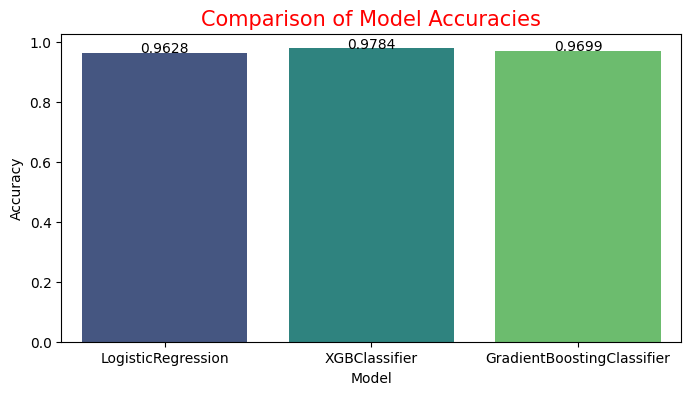

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(x=result_df.index, y=result_df['Accuracy'], palette="viridis")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies', color = 'red',fontsize=15)

# Add values above bars using Seaborn's annotate function
for index, value in enumerate(result_df['Accuracy']):
    plt.annotate(round(value, 4), (index, value + 0.001), ha="center", color='black')

plt.show()

## Heatmap

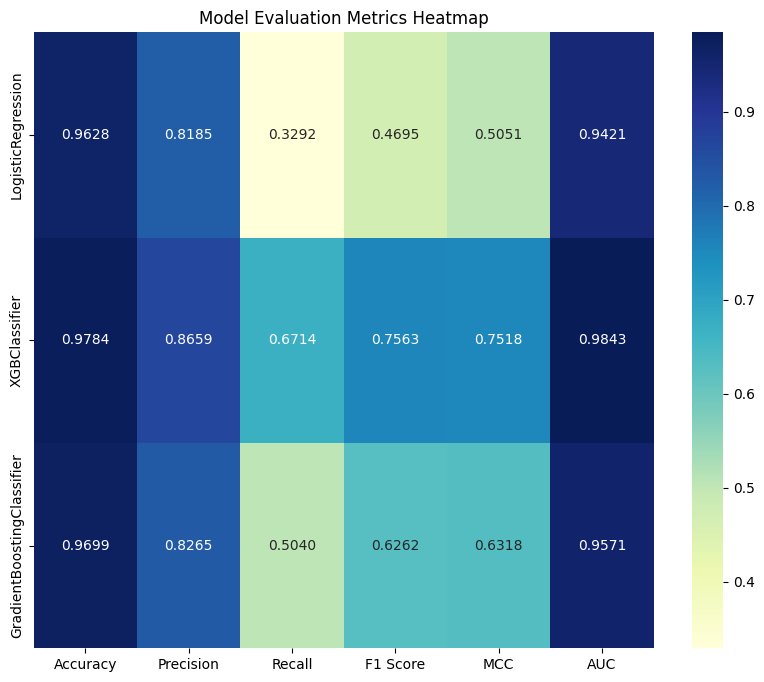

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(result_df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title('Model Evaluation Metrics Heatmap')
plt.show()

## Grouped Bar Chart 

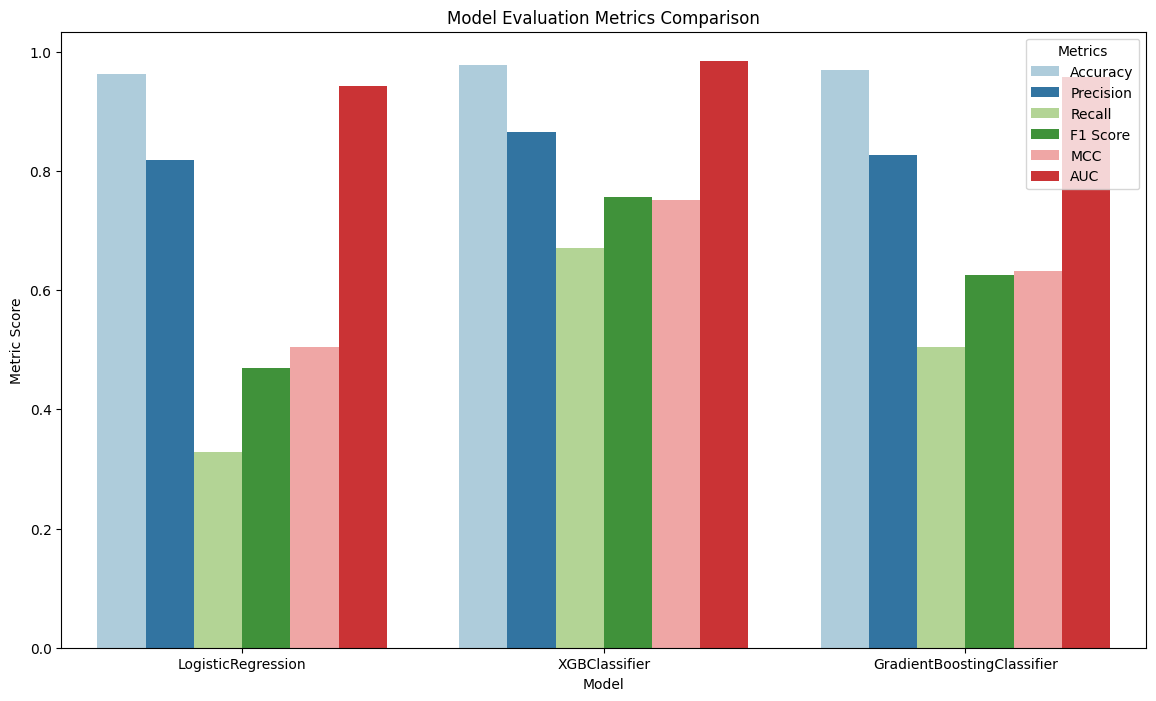

In [27]:
# Mengkonversi hasil ke DataFrame dan mereset index
result_df = pd.DataFrame(results).T.reset_index().melt(id_vars='index')

# Mengatur ukuran dan palet warna
plt.figure(figsize=(14, 8))
sns.set_palette("Paired")
sns.barplot(x='index', y='value', hue='variable', data=result_df)

# Mengatur label dan judul
plt.xlabel('Model')
plt.ylabel('Metric Score')
plt.title('Model Evaluation Metrics Comparison')
plt.legend(title='Metrics')
plt.show()

## Spider/Radar Chart

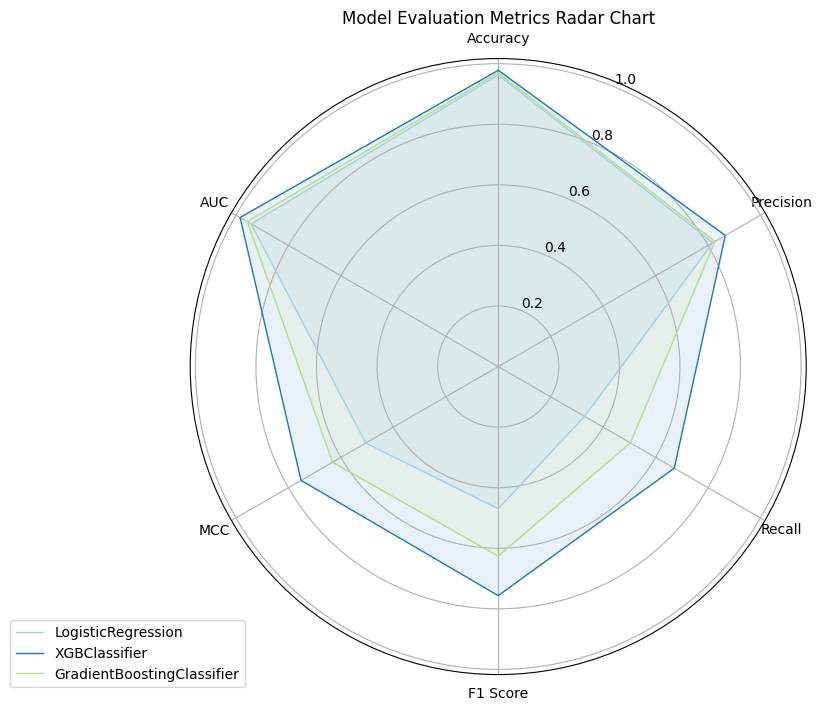

In [28]:
from math import pi

# Mengkonversi hasil ke DataFrame
result_df = pd.DataFrame(results).T

# Inisialisasi spider chart
categories = list(result_df.columns)
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8, 8))

for i, (model, metrics) in enumerate(result_df.iterrows()):
    values = metrics.tolist()
    values += values[:1]
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Evaluation Metrics Radar Chart')
plt.show()